# Multilayer perceptron (MLP)
## Regression advanced

In [1]:
import os

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
%matplotlib inline
sns.set_theme(context='notebook', style='whitegrid')

#### Funktionen zum Ploten der Trainingsergebnisse

In [3]:
def plot_results(epochs, history, metric='mean_absolute_error'):
    f, axes = plt.subplots(1,2, figsize=(12,4))

    ax = axes[0]
    sns.lineplot(x=range(epochs), y=history.history['loss'], label='Training', ax=ax)
    sns.lineplot(x=range(epochs), y=history.history['val_loss'], label='Validation', ax=ax)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    ax = axes[1]
    sns.lineplot(x=range(epochs), y=history.history[metric], label=f'Training', ax=ax)
    sns.lineplot(x=range(epochs), y=history.history[f'val_{metric}'], label=f'Validation', ax=ax)
    ax.set_xlabel("Epochs")
    ax.set_ylabel(metric)

    f.tight_layout()
    plt.show()

### Daten einlesen

In [4]:
# adjust to correct path if necessary
df_rental_bikes = pd.read_csv("../Datasets/rental_bikes.csv")

### Überblick über Daten bekommen

In [5]:
df_rental_bikes.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [6]:
df_rental_bikes.describe().round(2)

,Rented Bike Count,Hour,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00
mean,704.60,11.50,12.88,58.23,1.72,1436.83,4.07,0.57,0.15,0.08
std,645.00,6.92,11.94,20.36,1.04,608.30,13.06,0.87,1.13,0.44
min,0.00,0.00,-17.80,0.00,0.00,27.00,-30.60,0.00,0.00,0.00
25%,191.00,5.75,3.50,42.00,0.90,940.00,-4.70,0.00,0.00,0.00
50%,504.50,11.50,13.70,57.00,1.50,1698.00,5.10,0.01,0.00,0.00
75%,1065.25,17.25,22.50,74.00,2.30,2000.00,14.80,0.93,0.00,0.00
max,3556.00,23.00,39.40,98.00,7.40,2000.00,27.20,3.52,35.00,8.80


### Daten vorbereiten

#### Wochentag als Merkmal anlegen

In [7]:
df_rental_bikes['weekday'] = pd.to_datetime(df_rental_bikes.Date, dayfirst=True ).dt.weekday

#### Zielvariable und nicht benötigte Variable entfernen

In [8]:
df_rental_bikes_features = df_rental_bikes.drop(columns=['Rented Bike Count', 'Date'])

#### Kategorische Variablen in Dummyvariablen umwandeln

In [9]:
df_rental_bikes_features = pd.get_dummies(df_rental_bikes_features, columns=['Seasons', 'Holiday', 'Functioning Day'], drop_first=True)

In [10]:
df_rental_bikes_features

,Hour,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),weekday,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Functioning Day_Yes
0,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,4,0,0,1,1,1
1,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,4,0,0,1,1,1
2,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,4,0,0,1,1,1
3,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,4,0,0,1,1,1
4,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,4,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,4,0,0,0,1,1
8756,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,4,0,0,0,1,1
8757,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,4,0,0,0,1,1
8758,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,4,0,0,0,1,1


### Standardisieren

In [11]:
scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

In [12]:
df_rental_bikes_features.loc[:, "Hour": "Solar Radiation (MJ/m2)"] = scaler.fit_transform(df_rental_bikes_features.loc[:, "Hour": "Solar Radiation (MJ/m2)"])
df_rental_bikes_features.loc[:, ["Rainfall(mm)", "Snowfall (cm)"]] = min_max_scaler.fit_transform(df_rental_bikes_features.loc[:, ["Rainfall(mm)", "Snowfall (cm)"]])

In [13]:
df_rental_bikes_features.loc[:, "Hour": "weekday"].describe().round(2)

,Hour,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),weekday
count,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.0
mean,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.01,3.0
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.03,0.05,2.0
min,-1.66,-2.57,-2.86,-1.66,-2.32,-2.66,-0.66,0.00,0.00,0.0
25%,-0.83,-0.79,-0.80,-0.80,-0.82,-0.67,-0.66,0.00,0.00,1.0
50%,0.00,0.07,-0.06,-0.22,0.43,0.08,-0.64,0.00,0.00,3.0
75%,0.83,0.81,0.77,0.55,0.93,0.82,0.42,0.00,0.00,5.0
max,1.66,2.22,1.95,5.48,0.93,1.77,3.40,1.00,1.00,6.0


#### Für spätere Validierung Daten in Train- und Testset aufteilen

In [14]:
RANDOM_STATE = 42

keras.utils.set_random_seed(RANDOM_STATE)

In [15]:
X = df_rental_bikes_features.to_numpy()
y = df_rental_bikes['Rented Bike Count'].to_numpy()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)

# Aufgabe
## Model Setup
Wählen Sie nun die passenden Layer aus. Beginnen Sie am besten mit einem einfachen Modell und erweitern Sie es nach und nach.
Mögliche Layer sind:
- Dense
- Dropout
- BatchNormalization

Weitere mögliche Erweiterungen sind:
- Alternative Wahl des Optimizers. Hier ist eine Liste möglicher Optionen: https://keras.io/api/optimizers/#available-optimizers
- Weight Decay mit `keras.regularizers.l2()`
- Early Stopping Callback mit `keras.EarlyStopping()`

Außerdem können Sie Hyperparamter anpassen:
- Learning Rate des Optimizers
- Activation Functions der Hidden Layer `("tanh", "relu", "elu")`
- Anzahl Neuronen der Layer
- Batch size
- Epochs

In [17]:
input_dim = X_train.shape[1]

regularizer = keras.regularizers.l2(0.001)

In [18]:
model = keras.models.Sequential([
    keras.layers.Input(shape=input_dim),
    keras.layers.Dense(200, activation='relu', kernel_regularizer=regularizer), # kernel_initializer="he_normal",
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(200, activation='relu', kernel_regularizer=regularizer), # kernel_initializer="he_normal",
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='linear'),
])

In [19]:
LR = 1e-3
BATCHSIZE = 64
EPOCHS = 50

In [20]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=keras.losses.MeanSquaredError(),               ## Wird als Metrik für das Netzwerk verwendet um Error zu berechnen
    metrics=keras.losses.MeanAbsoluteError(),           ## Nur für Monitoring, intern wird nichts mit diesem Wert gemacht
)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               3200      
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                        

In [22]:
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(
    x=X_train, y=y_train,
    batch_size=BATCHSIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=[earlystopping]
)

Epoch 1/50
74/74 [==============================] - 1s 5ms/step - loss: 864720.7500 - mean_absolute_error: 687.3358 - val_loss: 791328.8125 - val_mean_absolute_error: 660.4016
Epoch 2/50
74/74 [==============================] - 0s 3ms/step - loss: 413629.4375 - mean_absolute_error: 459.3929 - val_loss: 328199.9375 - val_mean_absolute_error: 411.2547
Epoch 3/50
74/74 [==============================] - 0s 3ms/step - loss: 217620.2500 - mean_absolute_error: 335.1520 - val_loss: 224371.4531 - val_mean_absolute_error: 334.8730
Epoch 4/50
74/74 [==============================] - 0s 3ms/step - loss: 193716.3750 - mean_absolute_error: 317.7358 - val_loss: 182566.3438 - val_mean_absolute_error: 307.9472
Epoch 5/50
74/74 [==============================] - 0s 3ms/step - loss: 170793.2500 - mean_absolute_error: 297.8186 - val_loss: 149766.3438 - val_mean_absolute_error: 282.9823
Epoch 6/50
74/74 [==============================] - 0s 3ms/step - loss: 154692.1094 - mean_absolute_error: 280.7594 - va

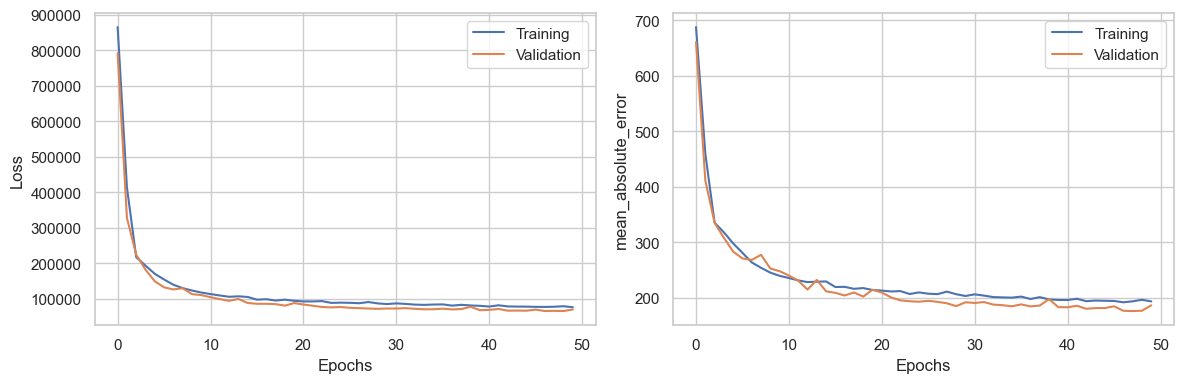

In [23]:
plot_results(len(history.epoch), history)

### Validierung

<img src="../Bilder/rmse.png" alt="Root Mean Squared Error" height="100"/>

Überprüfen Sie im letzten Schritt, wie gut Ihr Modell Vorhersagen machen kann anhand des RMSE (Root Mean Squared Error) und vergleichen Sie es damit den Durchschnitt vorherzusagen. 

#### Baseline Ergebnis

In [24]:
y_mean = np.repeat(np.mean(y_train), len(y_test))

rmse_baseline = mean_squared_error(y_test, y_mean, squared=False).round(2)
mae_baseline = mean_absolute_error(y_test, y_mean).round(2)


print(f"RMSE: {rmse_baseline}")
print(f"MAE: {mae_baseline}")

RMSE: 643.51
MAE: 519.77


#### Modell Ergebnis

In [25]:
y_pred = model.predict(X_test)

rmse_test = mean_squared_error(y_test, y_pred, squared=False).round(2)
mae_test = mean_absolute_error(y_test, y_pred).round(2)

print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")

RMSE: 285.33
MAE: 190.61
